## Importing libraries and setting up result object

In [1]:
 !pip install autograd==1.5 lifelines==0.27.4 matplotlib==3.6.2

In [2]:
from lifelines import KaplanMeierFitter
import autograd.numpy as np
from autograd.scipy.stats import norm
import math
from lifelines.utils.safe_exp import safe_exp
from lifelines.fitters import ParametricUnivariateFitter
from lifelines.fitters import ParametricRegressionFitter
import matplotlib.pyplot as plt
import sys

result = {}

### Next reading up the data from data file and generating a plot to preview precipitation

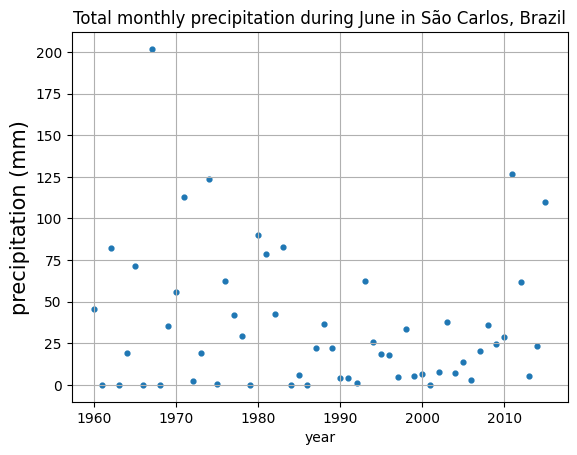

In [3]:
f = open('data.txt',"r")
precipitation=[]
for line in f:
    val = float(line.strip('\n'))
    val = val if val > 0 else sys.float_info.min
    precipitation.append(val)

fig, ax = plt.subplots()
date_range = range(1960, 2016)

ax.set(title='Total monthly precipitation during June in São Carlos, Brazil')
plt.xlabel('year', fontsize=10)
plt.ylabel('precipitation (mm)', fontsize=15)
ax.scatter(date_range, precipitation, s=12)
ax.grid()
plt.show()

### Basic functions clean up data for preview , they are used in table generation later

In [4]:
def cleanVal(val, places=6):
    return str(round(float(val), places))

def clean(val):
     return val if val != "" else "-"

def cleanStandards(fitter, key):
    try:
        se = fitter._compute_standard_errors()[key].to_list()[0]
        count = 56
        return cleanVal(se) #+ " / " + cleanVal(se * np.sqrt(count))
    except:
        return " - "

{'lambda': '1.586317 / 1.113064', 'beta': '0.019156 / 0.006892', 'p': '', 'AIC': 511.52916505608425, 'BIC': 515.5798684375545}


<AxesSubplot: >

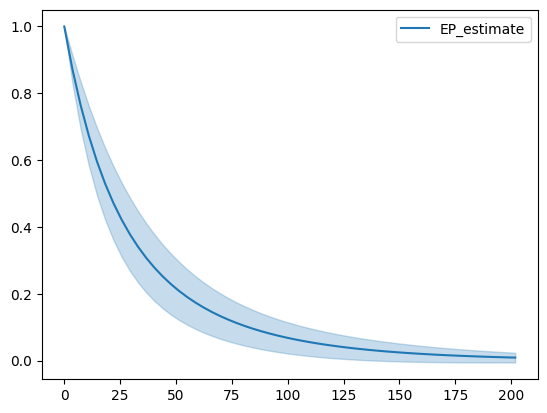

In [5]:
class EP(ParametricUnivariateFitter):
    _fitted_parameter_names = ['lambda_', 'beta_']  
    _bounds = ((0, None), (None, None))
    _KNOWN_MODEL = True
    def _cumulative_hazard(self, params, times):
        lambda_, beta_ = params
        CDF = (safe_exp(lambda_ * safe_exp(-1 * beta_ * times)) - safe_exp(lambda_))/(1 - safe_exp(lambda_)).cumsum()
        v = -np.log( 1 - CDF )
        return v

EP_Fitter = EP()
EP_Fitter.fit(precipitation, event_observed=date_range)

result["EP"] = { 
    "lambda" : cleanVal(EP_Fitter.params_["lambda_"]) + " / " + cleanStandards(EP_Fitter, "lambda_"),
    "beta" : cleanVal(EP_Fitter.params_["beta_"]) + " / " + cleanStandards(EP_Fitter, "beta_"),
    "p" : "",
    "AIC" : EP_Fitter.AIC_,
    "BIC" : EP_Fitter.BIC_,
}

print(result["EP"])
EP_Fitter.plot_survival_function()

{'lambda': '7.320422 / 5.293414', 'beta': '0.004625 / 0.003927', 'p': '', 'AIC': 513.4423266422898, 'BIC': 517.4930300237602}


<AxesSubplot: >

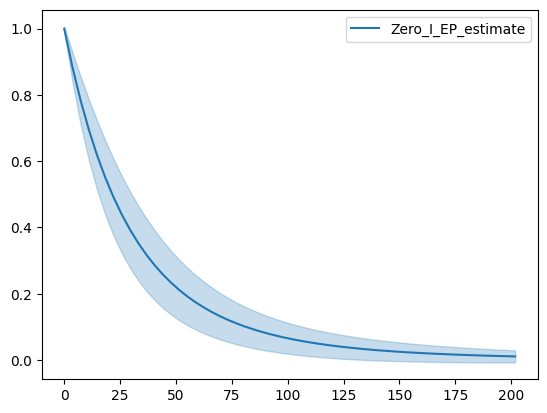

In [6]:
class Zero_I_EP(ParametricUnivariateFitter):
    _fitted_parameter_names = ['lambda_', 'beta_']
    _bounds = ((0, None), (None, None))
    _KNOWN_MODEL = True
    def _cumulative_hazard(self, params, times):
        lambda_, beta_ = params
        CDF = safe_exp(-1 * lambda_) + 1 - safe_exp(-1* lambda_ + lambda_ * safe_exp(-1 * beta_ * times))
        v = -1 * np.log( 1 - CDF )
        return v

Zero_I_EP_Fitter = Zero_I_EP()
Zero_I_EP_Fitter.fit(precipitation, event_observed=date_range)

result["ZI EP"] = { 
    "lambda" : cleanVal(Zero_I_EP_Fitter.params_["lambda_"]) + " / " + cleanStandards(Zero_I_EP_Fitter, "lambda_"),
    "beta" : cleanVal(Zero_I_EP_Fitter.params_["beta_"]) + " / " + cleanStandards(Zero_I_EP_Fitter, "beta_"),
    "p" : "",
    "AIC" : Zero_I_EP_Fitter.AIC_,
    "BIC" : Zero_I_EP_Fitter.BIC_
}

print(result["ZI EP"])
Zero_I_EP_Fitter.plot_survival_function()

{'lambda': '1.58636 / 1.113097', 'beta': '0.019156 / 0.006892', 'p': '1e-09 / 0.133631', 'AIC': 513.5291651676621, 'BIC': 519.6052202398675}


<AxesSubplot: >

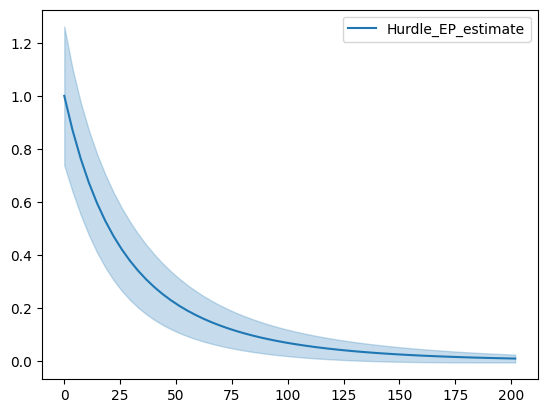

In [7]:
class Hurdle_EP(ParametricUnivariateFitter):
    _fitted_parameter_names = ['p_' , 'lambda_', 'beta_']
    _bounds = ((0, 1), (None, None), (None, None))
    _KNOWN_MODEL = True
    def _cumulative_hazard(self, params, times):
        p_, lambda_, beta_ = params
        f_l_b = (safe_exp(lambda_ * safe_exp(-1 * beta_ * times)) - safe_exp(lambda_))/(1 - safe_exp(lambda_))
        CDF = (p_ + ((1 - p_) * f_l_b))
        v = -1 * np.log( 1 - CDF )
        return v

Hurdle_EP_Fitter = Hurdle_EP()
Hurdle_EP_Fitter.fit(precipitation, event_observed=date_range)

result["Hurdle EP"] = { 
    "lambda" : cleanVal(Hurdle_EP_Fitter.params_["lambda_"]) + " / " + cleanStandards(Hurdle_EP_Fitter, "lambda_"),
    "beta" : cleanVal(Hurdle_EP_Fitter.params_["beta_"]) + " / " + cleanStandards(Hurdle_EP_Fitter, "beta_"),
    "p" : cleanVal(Hurdle_EP_Fitter.params_["p_"], 10) + " / " + cleanStandards(Hurdle_EP_Fitter, "p_"),
    "AIC" : Hurdle_EP_Fitter.AIC_,
    "BIC" : Hurdle_EP_Fitter.BIC_,
}

print(result["Hurdle EP"])
Hurdle_EP_Fitter.plot_survival_function()

{'lambda': '', 'beta': '0.028377 / 0.003792', 'p': '1e-09 / 0.133631', 'AIC': 514.9620916610468, 'BIC': 519.012795042517}


<AxesSubplot: >

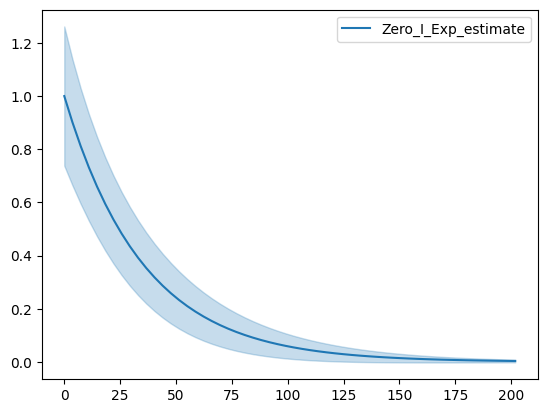

In [8]:
class Zero_I_Exp(ParametricUnivariateFitter):
    _fitted_parameter_names = ['p_', 'beta_']
    _bounds = ((0, 1), (None, None))
    _KNOWN_MODEL = True
    def _cumulative_hazard(self, params, times):
        p_, beta_ = params
        CDF = 1 - ( ( 1 - p_ ) * math.e ** ( -1 * beta_ * times ) )
        v = -1 * np.log( 1 - CDF )
        return v

Zero_I_Exp_Fitter = Zero_I_Exp()
Zero_I_Exp_Fitter.fit(precipitation, event_observed=date_range)

result["ZI EXP"] = { 
    "lambda" : "",
    "beta" : cleanVal(Zero_I_Exp_Fitter.params_["beta_"]) + " / " + cleanStandards(Zero_I_Exp_Fitter, "beta_"),
    "p" : cleanVal(Zero_I_Exp_Fitter.params_["p_"], 10) + " / " + cleanStandards(Zero_I_Exp_Fitter, "p_"),
    "AIC" : Zero_I_Exp_Fitter.AIC_,
    "BIC" : Zero_I_Exp_Fitter.BIC_
}

print(result["ZI EXP"])
Zero_I_Exp_Fitter.plot_survival_function()

### Graph generation: All models are overlapped ( ci_show has been disabled ) 

In [9]:
KMF_Fitter = KaplanMeierFitter()
KMF_Fitter.fit(precipitation, event_observed=date_range)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 56 total observations, 0 right-censored observations>

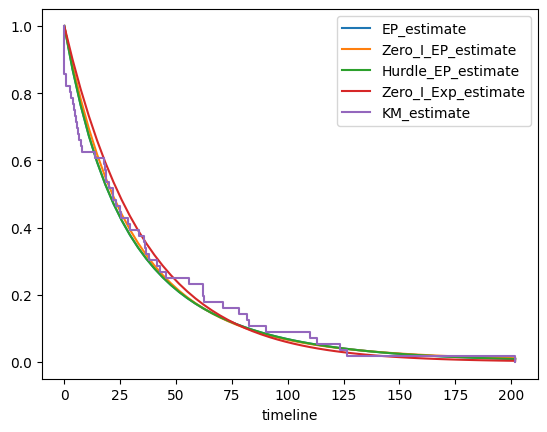

In [10]:
ax = EP_Fitter.plot_survival_function(ci_show=False)
ax = Zero_I_EP_Fitter.plot_survival_function(ci_show=False)
ax = Hurdle_EP_Fitter.plot_survival_function(ci_show=False)
ax = Zero_I_Exp_Fitter.plot_survival_function(ci_show=False)
ax = KMF_Fitter.plot_survival_function(ax=ax, ci_show=False)
plt.show()

In [11]:
print("-"*120)
print("{:<20} {:<20}".format("", "Note : Parameters in form : Value / Standard Error"))
print("-"*120)
print("{:<20} {:<40} {:<40} {:<40}".format("Model", "λ", "β", "p"))
print("-"*120)
for k, v in result.items():
    lambda_, beta_, p_, aic_, bic_ = v
    l = clean(v[lambda_])
    b = clean(v[beta_])
    p = clean(v[p_])
    aic = clean(v[aic_])
    bic = clean(v[bic_])
    print ("{:<20} {:<40} {:<40} {:<40}".format(k,l,b,p))
print("-"*120)
print()
print()
print("{:<20} {:<40} {:<40}".format("Model", "AIC", "BIC"))
print("-"*120)
for k, v in result.items():
    lambda_, beta_, p_, aic_, bic_ = v
    aic = cleanVal(v[aic_], 5)
    bic = cleanVal(v[bic_], 5)
    print ("{:<20} {:<40} {:<40}".format(k,aic, bic))
print("-"*120)

------------------------------------------------------------------------------------------------------------------------
                     Note : Parameters in form : Value / Standard Error
------------------------------------------------------------------------------------------------------------------------
Model                λ                                        β                                        p                                       
------------------------------------------------------------------------------------------------------------------------
EP                   1.586317 / 1.113064                      0.019156 / 0.006892                      -                                       
ZI EP                7.320422 / 5.293414                      0.004625 / 0.003927                      -                                       
Hurdle EP            1.58636 / 1.113097                       0.019156 / 0.006892                      1e-09 / 0.133631              

##

##

### Output of λ , β and AIC matches the output in original paper [19]

![Output of EP Model](output.png "Output of EP Model")

![Paper output](paper.png "Exponential-Poisson distribution: estimation and applications to rainfall and aircraft data with zero occurrence Francisco Louzadaa, Pedro Luiz Ramosa∗ and Paulo Henrique Ferreira")